#**모델 튜닝**

앞서 진행했던 과정에서 sklearn에서 제공하는 SGDClassifier 클래스를 통해 로지스틱 회귀 문제에 경사하강법을 적용해보았었다.   
이때 사용했던 loss 파라미터의 값은 'log'였다.
> loss='log'는 로지스틱 손실함수를 적용한다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import SGDClassifier
cancer = load_breast_cancer()
c_data = cancer.data
c_target = cancer.target
train_data, test_data, train_target, test_target = train_test_split(c_data, c_target, stratify=c_target, test_size=0.2, random_state=42)

In [ ]:
sgd = SGDClassifier(loss='log', random_state=42)  # 로지스틱 손실함수 적용
sgd.fit(train_data, train_target)
sgd.score(test_data, test_target)

0.8333333333333334

위의 모델에서는 정확도가 약 83% 정도 나오는 것을 볼 수 있다.   
여기서 loss는 모델이 알아서 학습하는 것이 아닌 사용자가 직접 '정의'해줘야 하는 값으로, 이러한 파라미터를 **'하이퍼파라미터'**라고 한다.   
이제 loss 값을 바꾸고 실제로 모델의 성능이 좋아지는지 확인해보도록 하자.

In [ ]:
sgd = SGDClassifier(loss='hinge', random_state=42)  # loss='hinge' hinge는 Support Vector Machine 문제를 푸는 모델로 만들어줌
sgd.fit(train_data, train_target)
sgd.score(test_data, test_target)

0.9385964912280702

93%의 정확도로 더 좋은 성능을 내는 것을 볼 수 있다.   
이러한 작업을 **'모델을 튜닝한다'**라고 표현한다.

이렇게 튜닝을 통해 좋은 성능을 가진 모델을 만들었지만, 이 모델은 실전에서 좋은 성능을 내지 못할 가능성이 높다.

그 이유는 모델이 마치 시험지를 외우듯이, 테스트 세트에 한해서만 좋은 성능을 낼 확률이 높다.   
이런 현상을 **'테스트셋의 정보가 모델에 새어 나갔다'**라고 한다.   

테스트 세트로 모델을 튜닝하면 테스트 세트의 정보가 모델에 새어 나가므로, 일반화된 성능이 왜곡된다.   

이를 해결하기 위해서, 모델을 튜닝할 때 테스트 세트를 사용하지 않는 대신,   
**'검증 세트'**를 별도로 구분하고 검증세트를 통해 튜닝하면 된다.

#**검증 세트 준비**

모델 튜닝을 위한 검증 세트(validation set)를 따로 준비한다.

검증세트는 훈련세트에서 떼어내어 만들고, 약 훈련:검증=8:2 정도의 비율로 할당한다.

In [ ]:
train_data, val_data, train_target, val_target = train_test_split(train_data, train_target, stratify=train_target, test_size=0.2, random_state=42)
print(len(train_data), len(val_target))

364 91


In [ ]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(train_data, train_target)
sgd.score(val_data, val_target)

0.6923076923076923

#**데이터 전처리와 스케일**

데이터셋에 누락된 데이터가 있거나 형태가 균일하지 않은 경우 이를 적절하게 가공해야 한다.

이를 **'데이터 전처리(data preprocession)'**이라고 한다.

###**특성 스케일**

||당도|무게|
|:---:|:----:|:----:|
|사과1|4|540|
|사과2|8|700|
|사과3|2|480|

위의 표를 보면 사과의 당도 범위는 (1 ~ 10)인데에 비해 무게는 (500 ~ 1000)범위이다.   
이런 경우를 보고 **'스케일 차이가 크다'**라고 한다.

스케일의 차이가 큰 경우, 스케일에 민감한 경사하강법을 사용할 때 특성의 스케일을 조정할 필요가 있다.

###**스케일 조정하지 않고 훈련할 경우**

스케일 차이가 큰 특성을 비교하기 위해 유방암 데이터셋에서 mean perimeter와 mean area 특성을 사용하도록 하자.

['mean perimeter' 'mean area']


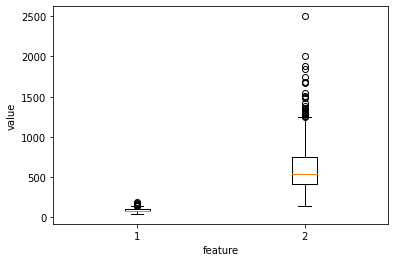

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(cancer.feature_names[[2, 3]])
plt.boxplot(train_data[:, 2:4])
plt.xlabel("feature")
plt.ylabel("value")
plt.show()

mean perimeter는 (100 ~ 200) 사이의 범위이고, mean area는 (200 ~ 2000) 사이의 범위이다. 

이제 스케일을 조정하지 않고 그대로 모델을 훈련시킬 건데,   
기존에 구현했던 SingleLayer 클래스에 인스턴스 변수를 추가하여 가중치 값을 저장하여 변화를 관찰해볼 것이다.   
또한 학습률이라는 개념을 도입하여 가중치의 업데이트 양을 조절할 것이다.

>학습률을 적절히 지정하여 가중치가 너무 큰 폭으로 업데이트 되어 손실 그래프의 전역 최소값을 지나쳐 버리지 않게 조절한다.

In [ ]:
class SingleLayer:

  def __init__(self, learning_rate=0.1):
    self.w = None   # 입력데이터의 특성이 많아 가중치와 절편을 미리 초기화하지 않는다.
    self.b = None   # 나중에 입력데이터를 보고 특성 개수에 맞게 결정
    self.losses = []
    self.w_history = []   # 가중치를 저장할 리스트
    self.lr = learning_rate   # 학습률 

  def forpass(self, x):
    z = np.sum(self.w * x) + self.b   # x와 w는 1차원 배열이므로 np.sum을 이용해 모든 요소를 다 더한다.
    return z


  def backprop(self, x, err):   # 오차역전파 메서드
    w_grad = x * err
    b_grad = err
    return w_grad, b_grad


  def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])  # 가중치와 절편 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  # 가중치 기록 -> 넘파이 배열(w)을 추가하면 실제값이 추가되는 것이 아닌 배열을 참조하기 때문에 w값이 바뀌면 그 값을 복사하여 추가해주어야 한다.
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 샘플 개수만큼의 인덱스 섞기
      for i in indexes:
        z = self.forpass(x[i])   # 정방향 계산
        a = self.activation(z)  # 정방향 계산의 결과값인 z를 활성화 함수에 통과
        err =  -(y[i] - a)       # 활성화 함수를 거친 a값으로 오차량 계산
        w_grad, b_grad = self.backprop(x[i], err)  # 오차역전파
        self.w -= self.lr * w_grad   # 그레이디언트 업데이트  (학습률 적용)
        self.b -= b_grad
        self.w_history.append(self.w.copy())  # 가중치 기록
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))  # 로지스틱 손실함수 -(ylog(a) - (1 - y)log(1 - a))
      self.losses.append(loss/len(y))


  def activation(self, z):  # 활성화 함수
    z = np.clip(z, -100, None)    # 안전한 계산을 위해 클리핑
    a = 1 / (1 + np.exp(-z))
    return a


  def predict(self, x): # 예측 함수
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0  # 계단함수


  def score(self, x, y):    # 평가함수
    return np.mean(self.predict(x) == y)

In [ ]:
layer1 = SingleLayer()
layer1.fit(train_data, train_target)
layer1.score(val_data, val_target)


0.9120879120879121

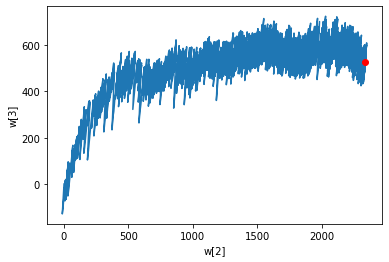

In [ ]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])   # 세 번째 요소(mean perimeter)
  w3.append(w[3])   # 네 번쨰 요소(mean area)
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

그래프를 보면 w3(mean area)이 w2(mean perimeter)보다 스케일이 크므로,   
학습 과정에서 큰 폭으로 흔들리며 변화하는 것을 볼 수 있다.

이를 'w3에 대한 그레이디언트가 크기 때문에 w3 축을 따라 가중치가 크게 요동친다'라고 한다.

이를 해결하기 위해서 스케일 조정이 필요하다.

#**Standardization: 표준화**

표준화는 신경망에서 자주 사용하는 스케일 조정 방식으로, 특성값에서 평균을 빼고 표쥰편차로 나누면 된다.
###$$
  (표준화 공식) \quad z = \frac{x - μ}{s}
$$

표준화를 하면 평균이 0이고 분산이 1인 특성이 만들어진다.

이제 넘파이를 이용해서 표준화를 구현해보자.

In [ ]:
train_mean = np.mean(train_data, axis=0)  # 평균
train_std = np.std(train_data, axis=0)    # 분산
train_data_scaled = (train_data - train_mean) / train_std   # 표준화

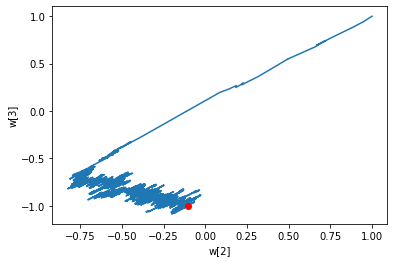

In [ ]:
layer2 = SingleLayer()
layer2.fit(train_data_scaled, train_target)
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel("w[2]")
plt.ylabel("w[3]")
plt.show()

In [ ]:
layer2.score(val_data, val_target)

0.37362637362637363

w2(mean perimeter)와 w3(mean area)가 비슷한 비율로 조정되었기 때문에 대각선 방향으로 가중치가 이동했고, 최적값에 빠르게 근접하고 있음을 알 수 있다.   
하지만 모델을 평가했을 때, 성능이 매우 안좋게 나오고 있다.   

그 이유는 검증세트는 스케일 조정이 안되어 있기 때문이다.   
이를 해결하기 위해 검증세트도 표준화 전처리 과정을 거쳐주자.

In [ ]:
val_mean = np.mean(val_data, axis=0)
val_std = np.std(val_data, axis=0)
val_data_scaled = (val_data - val_mean) / val_std
layer2.score(val_data_scaled, val_target)

0.967032967032967

##**실수하기 쉬운 함정**

여기서 '함정'은 **'훈련세트와 검증세트가 다른 비율로 스케일 조정된 경우'**를 말한다.   
원본 훈련세트와 검증세트, 전처리된 훈련세트와 검증세트를 각각 50개씩 뽑아 산점도를 그린 후 비교해보자.


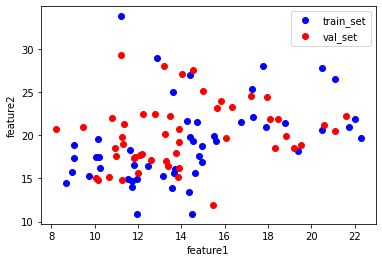

In [ ]:
# 원본 훈련/검증 세트 그래프

plt.plot(train_data[:50, 0], train_data[:50, 1], 'bo')
plt.plot(val_data[:50, 0], val_data[:50, 1], 'ro')
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend(['train_set', 'val_set'])
plt.show()

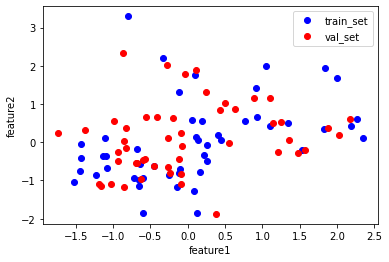

In [ ]:
# 전처리 훈련/검증 세트 그래프

plt.plot(train_data_scaled[:50, 0], train_data_scaled[:50, 1], 'bo')
plt.plot(val_data_scaled[:50, 0], val_data_scaled[:50, 1], 'ro')
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend(['train_set', 'val_set'])
plt.show()

원본과 전처리된 그래프를 비교해보면 점과 점 사이의 거리가 미세하게 차이나는 것을 볼 수 있다.    
이는 훈련세트와 검증세트를 다른 비율로 전처리했기 때문이다.

이를 해결하기 위해서는 검증세트를 표준화할 때, 훈련세트의 평균과 분산을 이용하는 것이다.
$$
(검증세트 표준화) = \frac{(검증세트 특성값) - (훈련세트 평균)}{(훈련세트 분산)}
$$

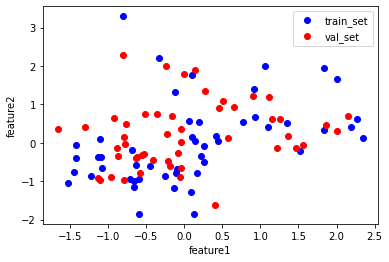

In [ ]:
val_data_scaled = (val_data - train_mean) / train_std
plt.plot(train_data_scaled[:50, 0], train_data_scaled[:50, 1], 'bo')
plt.plot(val_data_scaled[:50, 0], val_data_scaled[:50, 1], 'ro')
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend(['train_set', 'val_set'])
plt.show()

In [ ]:
layer2.score(val_data_scaled, val_target)

0.967032967032967